<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

**Цель исследования** - обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

**Критерий качества**: метрика качества *F1* не меньше 0.75. 

**Задачи исследования**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

## Подготовка

На первом этапе изучения данных, мы импортируем необходимые библиотеки, которые пригодятся для исследования, и изучим общую информацию о датасетах.

In [1]:
!pip install -U scikit-learn==1.1.3 -q
!pip install -U nltk -q
!pip install -U tqdm -q
!/opt/conda/bin/python -m pip install wordcloud==1.8.2.2 -q
!pip install --upgrade Pillow==9.5.0 -q
!pip install lightgbm -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from numpy.random import RandomState
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
import re
import sklearn as sk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV
)
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.metrics import f1_score
import spacy
from tqdm.notebook import tqdm
from wordcloud import WordCloud
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [3]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
plt.rcParams['figure.figsize'] = (6, 5)

In [5]:
def download(filename):
    df = pd.read_csv(filename, index_col = 0)
    display(df.head())
    display(df.sample(5))
    df.info()
    return df

In [6]:
data = download('/datasets/toxic_comments.csv')

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


,text,toxic
5626,""":Provide reliable sources, or your edits will...",0
54692,From layout. Please put back if necessary. \n...,0
150394,"My mistake, then. See you around. -",0
43657,Cost \nI see no explanation of the cost of att...,0
73201,"""\n\n Original fair-use rationale discussion \...",0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


**Описание данных**
В датасете 2 столбца:
* `text` — текст комментария
* `toxic` — целевой признак

Количество значений совпадает во всех колонках, значит, вероятно, нет пропущенных данных. 

**Данные загружены, получена общая информация о них.**

In [7]:
def research(filename):
    isna = filename.isna().sum()
    print("Количество пропущенных значений\n", isna, "\n")
    per = isna/ len(filename) * 100
    print("Количество пропущенных значений в процентах\n", per, "\n")
    duplicates = filename.duplicated().sum()
    print("Количество дубликатов\n", duplicates, "\n")

In [8]:
research(data) 

Количество пропущенных значений
 text     0
toxic    0
dtype: int64 

Количество пропущенных значений в процентах
 text     0.0
toxic    0.0
dtype: float64 

Количество дубликатов
 0 



Пропущенных данных и дубликатов нет.

In [9]:
data['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

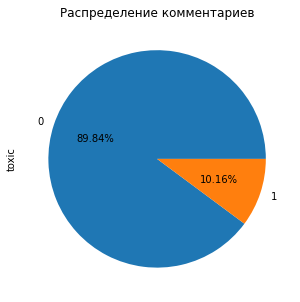

In [10]:
data['toxic'].value_counts().plot(kind='pie', autopct='%.2f%%', title= 'Распределение комментариев');

**Итак, на данном этапе исследования был загружен датасет, изученая общая информация о нём, выполнена предобработка данных, и построен графики по категориальному признаку датасета 'toxic', изучена информация о нём, сделаны следующие выводы:**
- пропущенных данных и дубликатов нет.
- удалён лишний столбец. 
- 143106 комментариев позитивны; 16186 негативны, в процентном соотношении позитивные комментарии составляют - 90%, негативные - 10%.

## Обучение

Лемматизируем и очистим текст.

In [11]:
nlp = spacy.load("en_core_web_sm")

def clear_text(text):
    cleaned_text = re.sub(r'[^a-zA-Z ]', ' ', text)
    cleaned_text = " ".join(cleaned_text.split())
    return cleaned_text

def lemmatize(text):
    doc = nlp(text)
    lemmatized_text = [token.lemma_ for token in doc]
    return ' '.join(lemmatized_text)

In [12]:
sentence1 = "The striped bats / are hanging on their feet for best"
sentence2 = "you should be ashamed ; of yourself went worked"
df_my = pd.DataFrame([sentence1, sentence2], columns = ['text'])
print(df_my)
print(' ')
print(df_my['text'].apply(clear_text))

                                                text
0  The striped bats / are hanging on their feet f...
1    you should be ashamed ; of yourself went worked
 
0    The striped bats are hanging on their feet for...
1        you should be ashamed of yourself went worked
Name: text, dtype: object


In [13]:
print(df_my)
print(' ')
print(df_my['text'].apply(clear_text).apply(lemmatize))

                                                text
0  The striped bats / are hanging on their feet f...
1    you should be ashamed ; of yourself went worked
 
0    the stripe bat be hang on their foot for good
1        you should be ashamed of yourself go work
Name: text, dtype: object


In [14]:
tqdm.pandas()

In [15]:
data['cleaned_text'] = data['text'].progress_apply(lambda x:clear_text(x))

  0%|          | 0/159292 [00:00<?, ?it/s]

In [16]:
data['lemma_text'] = data['cleaned_text'].progress_apply(lemmatize)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [17]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
data['lemma_text'] = data['lemma_text'].str.lower()

Обучим модель LogisticRegression

In [19]:
X = data['lemma_text']
y = data['toxic']
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE, test_size = TEST_SIZE, stratify=y)

создадим пайплайн

In [20]:
pipe_logistic = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, max_features=7000)),
    ('scaler', StandardScaler(with_mean=False)),
    ('model', LogisticRegression(random_state=RANDOM_STATE))
])

pipe_passive_aggressive = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, max_features=7000)),
    ('model', PassiveAggressiveClassifier(random_state=RANDOM_STATE))
])

pipe_lightgbm = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, max_features=7000)),
    ('model', LGBMClassifier(random_state=RANDOM_STATE))
])

param_grid_logistic = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

param_grid_passive_aggressive = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'model__max_iter': [1000, 2000, 3000]
}

param_grid_lightgbm = {
    'model__n_estimators': [100, 200, 300, 400]
}


In [21]:
grid_search_logistic = GridSearchCV(pipe_logistic, param_grid_logistic, cv=5, scoring='f1', n_jobs=-1)
grid_search_passive_aggressive = GridSearchCV(pipe_passive_aggressive, param_grid_passive_aggressive, cv=5,scoring='f1', n_jobs=-1)
grid_search_lightgbm = GridSearchCV(pipe_lightgbm, param_grid_lightgbm, cv=5, scoring='f1', n_jobs=-1)

In [22]:
grid_search_logistic.fit(X_train, y_train)
grid_search_passive_aggressive.fit(X_train, y_train)
grid_search_lightgbm.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=7000,
                                                        stop_words={'a',
                                                                    'about',
                                                                    'above',
                                                                    'after',
                                                                    'again',
                                                                    'against',
                                                                    'ain',
                                                                    'all', 'am',
                                                                    'an', 'and',
                                                                    'any',
                                                                    'are',
                                                                    'aren',
                                                                    "aren't",
                                                                    'as', 'at',
                                                                    'be',
                                                                    'because',
                                                                    'been',
                                                                    'before',
                                                                    'being',
                                                                    'below',
                                                                    'between',
                                                                    'both',
                                                                    'but', 'by',
                                                                    'can',
                                                                    'couldn',
                                                                    "couldn't", ...})),
                                       ('model',
                                        LGBMClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__n_estimators': [100, 200, 300, 400]},
             scoring='f1')

In [23]:
best_model_logistic = grid_search_logistic.best_estimator_
best_model_passive_aggressive = grid_search_passive_aggressive.best_estimator_
best_model_lightgbm = grid_search_lightgbm.best_estimator_

In [24]:
best_score_logistic = grid_search_logistic.best_score_
best_score_passive_aggressive = grid_search_passive_aggressive.best_score_
best_score_lightgbm = grid_search_lightgbm.best_score_

In [25]:
print("Best Logistic Regression Model:", best_model_logistic)
print("Best Logistic Regression Score:", best_score_logistic)
print("Best Passive Aggressive Classifier Model:", best_model_passive_aggressive)
print("Best Passive Aggressive Classifier Score:", best_score_passive_aggressive)
print("Best LightGBM Model:", best_model_lightgbm)
print("Best LightGBM Score:", best_score_lightgbm)

Best Logistic Regression Model: Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=7000,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('scaler', StandardScaler(with_mean=False)),
                ('model', LogisticRegression(C=0.001, random_state=42))])
Best Logistic Regression Score: 0.749637082769705
Best Passive Aggressive Classifier Model: Pipeline(steps=[('tfidf',
                 TfidfVect

Лучшая модель - Passive Aggressive Classifier Score с параметрами C=0.1, random_state=42.

In [26]:
y_pred_passive_aggressive = best_model_passive_aggressive.predict(X_test)
f1_score_passive_aggressive = f1_score(y_test, y_pred_passive_aggressive)
f1_score_passive_aggressive

0.7766001376462491

На тестовых данных модель дала метрику 0.78.

Создадим облако слов

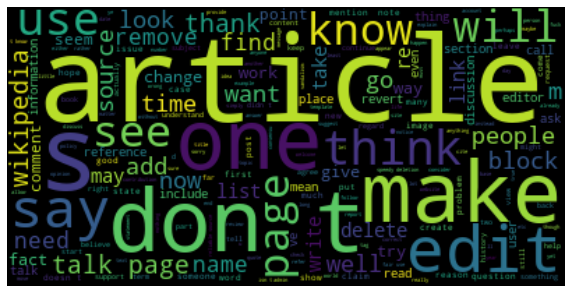

In [27]:
text_raw_train = " ".join(X_train)
text_raw_test = " ".join(X_test)
text_raw = text_raw_train + " " + text_raw_test

wordcloud = WordCloud().generate(text_raw)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Облако слов показало, что наиболее частотными словами являются article, edit, dont, one, will, make, use, see.

**Таким образом, лучшая модель - Passive Aggressive Classifier Score с параметрами C=0.1, random_state=42. На тестовых данных модель дала метрику 0.78. Облако слов показало, что наиболее частотными словами являются article, edit, dont, one, will, make, use, see. Модель прошла по критерию качества.**

## Выводы

Таким образом, наше исследование было проведено в несколько этапов:
- ознакомление с данными
- предобработка данных (на этом этапе были проверены данные на пропущенные значения, дубликаты).
- 143106 комментариев позитивны; 16186 негативны, в процентном соотношении позитивные комментарии составляют - 90%, негативные - 10%.
- обучена модель Passive Aggressive Classifier Score с параметрами C=0.1, random_state=42. 
- На тестовых данных модель дала метрику 0.78. 
- Облако слов показало, что наиболее частотными словами являются article, edit, dont, one, will, make, use, see.
Таким образом, данная модель обучена и готова для внедрения в бизнес.